In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
data_path = 'data/accepted_2007_to_2018q4.csv/accepted_2007_to_2018q4.csv'
df_accepted = pd.read_csv(data_path, low_memory=False)

In [45]:
target_mapping = {
    "Charged Off": 1,
    "Default": 1,
    "Late (31-120 days)": 1,
    "Does not meet the credit policy. Status:Charged Off": 1,
    "Fully Paid": 0,
    "Does not meet the credit policy. Status:Fully Paid": 0
} 

final_statuses_for_model = list(target_mapping.keys())
df_filtered = df_accepted[df_accepted['loan_status'].isin(final_statuses_for_model)].copy()
df_filtered['is_default'] = df_filtered['loan_status'].map(target_mapping)

y = df_filtered['is_default']

In [46]:
columns_to_drop = [
    # 1. Identifiers and Unnecessary Columns
    'id',
    'member_id',
    'url',
    'desc',
    'loan_status',
    'title',
    'zip_code',
    'emp_title',

    # 2. Data Leakage: Information that would not be available at the time of loan application, only available after the loan is issued or defaulted
    'funded_amnt',
    'funded_amnt_inv',
    'pymnt_plan',
    'out_prncp',
    'out_prncp_inv',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_prncp',
    'total_rec_int',
    'total_rec_late_fee',
    'recoveries',
    'collection_recovery_fee',
    'last_pymnt_d',
    'last_pymnt_amnt',
    'next_pymnt_d',
    'last_credit_pull_d',
    'last_fico_range_high',
    'last_fico_range_low',

    # 3. Hardship and Debt Settlement Information (outcomes of distress not related to the original loan application)
    'hardship_flag',
    'hardship_type',
    'hardship_reason',
    'hardship_status',
    'deferral_term',
    'hardship_amount',
    'hardship_start_date',
    'hardship_end_date',
    'payment_plan_start_date',
    'hardship_length',
    'hardship_dpd',
    'hardship_loan_status',
    'orig_projected_additional_accrued_interest',
    'hardship_payoff_balance_amount',
    'hardship_last_payment_amount',
    'debt_settlement_flag',
    'debt_settlement_flag_date',
    'settlement_status',
    'settlement_date',
    'settlement_amount',
    'settlement_percentage',
    'settlement_term',

    # 4. Joint/Secondary Borrower Information (not relevant for single borrower analysis)
    'annual_inc_joint',
    'dti_joint',
    'verification_status_joint',
    'revol_bal_joint',
    'sec_app_fico_range_low',
    'sec_app_fico_range_high',
    'sec_app_earliest_cr_line',
    'sec_app_inq_last_6mths',
    'sec_app_mort_acc',
    'sec_app_open_acc',
    'sec_app_revol_util',
    'sec_app_open_act_il',
    'sec_app_num_rev_accts',
    'sec_app_chargeoff_within_12_mths',
    'sec_app_collections_12_mths_ex_med',
    'sec_app_mths_since_last_major_derog',

    # 5. Columns with High Missing Values or Irrelevant Information
    'mths_since_last_delinq',
    'policy_code'
]

In [47]:
existing_columns_to_drop = [col for col in columns_to_drop if col in df_filtered.columns]
X = df_filtered.drop(columns=existing_columns_to_drop + ['is_default'], errors='ignore')

print("X and y DataFrames recreated for preprocessing.")
print(f"X shape: {X.shape}, y shape: {y.shape}")

X and y DataFrames recreated for preprocessing.
X shape: (1369566, 85), y shape: (1369566,)


In [48]:
X_processed = X.copy()

if 'issue_d' in X_processed.columns:
    print("Processing 'issue_d' column...")

    #Convert 'issue_d' to datetime
    X_processed['issue_d_dt'] = pd.to_datetime(X_processed['issue_d'], format='%b-%Y', errors='coerce')

    # Check for unparseable dates
    unparseable_dates = X_processed['issue_d_dt'].isnull().sum()
    if unparseable_dates > 0:
        print(f"Warning: {unparseable_dates} unparseable dates found in 'issue_d'. These will be dropped.")
    else:
        print("All dates in 'issue_d' were successfully parsed.")

    X_processed['issue_month'] = X_processed['issue_d_dt'].dt.month
    X_processed['issue_year'] = X_processed['issue_d_dt'].dt.year
    X_processed['issue_dayofweek'] = X_processed['issue_d_dt'].dt.dayofweek # Monday=0, Sunday=6

    X_processed.drop(columns=['issue_d'], inplace=True, errors='ignore')
    print("'issue_d' column processed and dropped.")
else:
    print("'issue_d' column not found in the DataFrame. Skipping processing.")
    

Processing 'issue_d' column...
All dates in 'issue_d' were successfully parsed.
'issue_d' column processed and dropped.


In [ ]:
if 'earliest_cr_line' in X_processed.columns:
    print("Processing 'earliest_cr_line' column...")
    X_processed['earliest_cr_line_dt'] = pd.to_datetime(X_processed['earliest_cr_line'], format='%b-%Y', errors='coerce')

    unparseable_cr_lines = X_processed['earliest_cr_line_dt'].isnull().sum()
    if unparseable_cr_lines > 0:
        print(f"Warning: {unparseable_cr_lines} unparseable dates found in 'earliest_cr_line'. These will be dropped.")
    else:
        print("All dates in 'earliest_cr_line' were successfully parsed.")
    
    if 'issue_d_dt' in X_processed.columns:
        X_processed['credit_history_length_months'] = ((X_processed['issue_d_dt'] - X_processed['earliest_cr_line_dt']).dt.days / 30.4375).astype(float) # Average days per month ; allow for NaN

        # Handle negative values, if somehow the earliest credit line is after the issue date
        X_processed.loc[X_processed['credit_history_length_months'] < 0, 'credit_history_length_months'] = np.nan
        print("Credit history length calculated successfully.")
    else:
        print("Warning: 'issue_d_dt' not found. Cannot calculate credit history length.")
    
    X_processed.drop(columns=['earliest_cr_line', 'earliest_cr_line_dt'], inplace=True, errors='ignore')
    print("'earliest_cr_line' column processed and dropped.")

else: # Almost sure this is not needed, but keeping for safety, if the column has already been split or removed (wasnt used in the original code)
    print("'earliest_cr_line' column not found in the DataFrame.")
    
    earliest_cr_line_encoded_cols = [col for col in X_processed.columns if col.startswith('earliest_cr_line_')] # This will be empty if the column was not processed

    if earliest_cr_line_encoded_cols:
        print(f"Warning: The following columns were not processed due to missing 'earliest_cr_line': {earliest_cr_line_encoded_cols}")

        date_from_col_name_map = {
            col: pd.to_datetime(col.replace('earliest_cr_line_', '').format('%b-%Y'), errors='coerce')
            for col in earliest_cr_line_encoded_cols
        }

        X_processed['credit_history_length_months'] = np.nan
        print("Calculating credit history length from encoded columns...")

        issue_d_dt = X_processed.get('issue_d_dt')

        for index, row_series in X_processed.iterrows():
            issue_date = issue_d_dt[index] if issue_d_dt is not None else pd.NaT

            if pd.isna(issue_date):
                continue

            earliest_date_for_row = None

            for col in earliest_cr_line_encoded_cols:
                if row_series[col] == 1:
                    earliest_date_for_row = date_from_col_name_map[col]
                    break
            if earliest_date_for_row and pd.notna(earliest_date_for_row):
                days_diff = (issue_date - earliest_date_for_row).days
                X_processed.loc[index, 'credit_history_length_months'] = days_diff / 30.4375  # Average days per month
                # handle negative values
                if X_processed.loc[index, 'credit_history_length_months'] < 0:
                    X_processed.loc[index, 'credit_history_length_months'] = np.nan
        
        X_processed.drop(columns=earliest_cr_line_encoded_cols, inplace=True, errors='ignore')
        print("Credit history length calculated from encoded columns.")
    else:
        print("No encoded columns for 'earliest_cr_line' found. Cannot calculate credit history length.")

Processing 'earliest_cr_line' column...
Credit history length calculated successfully.
'earliest_cr_line' column processed and dropped.


In [ ]:
if 'issue_d_dt' in X_processed.columns:
    X_processed.drop(columns=['issue_d_dt'], inplace=True, errors='ignore')
    print("'issue_d_dt' intermediate column dropped.")

print(f"\nFinal shape of X_processed: {X_processed.shape}")
print("First 5 rows of X_processed:\n", X_processed.head())

if 'issue_month' in X_processed.columns: # checking the status of NaNs after processing
    print(f"NaNs in 'issue_month': {X_processed['issue_month'].isnull().sum()}")
if 'credit_history_length_months' in X_processed.columns: 
    print(f"NaNs in 'credit_history_length_months': {X_processed['credit_history_length_months'].isnull().sum()}")

'issue_d_dt' intermediate column dropped.

Final shape of X_processed: (1369566, 87)
First 5 rows of X_processed:
    loan_amnt        term  int_rate  installment grade sub_grade emp_length  \
0     3600.0   36 months     13.99       123.03     C        C4  10+ years   
1    24700.0   36 months     11.99       820.28     C        C1  10+ years   
2    20000.0   60 months     10.78       432.66     B        B4  10+ years   
4    10400.0   60 months     22.45       289.91     F        F1    3 years   
5    11950.0   36 months     13.44       405.18     C        C3    4 years   

  home_ownership  annual_inc verification_status  ... tax_liens  \
0       MORTGAGE     55000.0        Not Verified  ...       0.0   
1       MORTGAGE     65000.0        Not Verified  ...       0.0   
2       MORTGAGE     63000.0        Not Verified  ...       0.0   
4       MORTGAGE    104433.0     Source Verified  ...       0.0   
5           RENT     34000.0     Source Verified  ...       0.0   

  tot_hi_cred

In [ ]:
log_transform_columns = [
    'loan_amnt', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
    'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
    'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq',
    'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m',
    'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
    'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
    'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
    'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
    'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
    'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
    'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd',
    'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
    'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
    'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
    'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
    'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit' # These were determined in EDA #1, with the observations of the distributions
]

print("\n--- Applying Log1p Transformation to Skewed/Sparse Numerical Features ---")
for col in log_transform_columns:
    if col in X_processed.columns:
        if (X_processed[col] < 0).any().any(): # check for negative values
            print(f"Warning: Column '{col}' contains negative values. Skipping log transformation.")
        else: 
            # Must Fill NaN values with 0 before log transformation
            # For now, we can handle them later
            X_processed[col] = np.log1p(X_processed[col])
            print(f"Log1p transformation applied to column: {col}")
    else:
        print(f"Column '{col}' not found in DataFrame. Skipping log transformation.")



--- Applying Log1p Transformation to Skewed/Sparse Numerical Features ---
Log1p transformation applied to column: loan_amnt
Log1p transformation applied to column: installment
Log1p transformation applied to column: annual_inc
Log1p transformation applied to column: delinq_2yrs
Log1p transformation applied to column: inq_last_6mths
Log1p transformation applied to column: open_acc
Log1p transformation applied to column: pub_rec
Log1p transformation applied to column: revol_bal
Log1p transformation applied to column: revol_util
Log1p transformation applied to column: total_acc
Log1p transformation applied to column: collections_12_mths_ex_med
Log1p transformation applied to column: mths_since_last_major_derog
Log1p transformation applied to column: acc_now_delinq
Log1p transformation applied to column: tot_coll_amt
Log1p transformation applied to column: tot_cur_bal
Log1p transformation applied to column: open_acc_6m
Log1p transformation applied to column: open_act_il
Log1p transformati

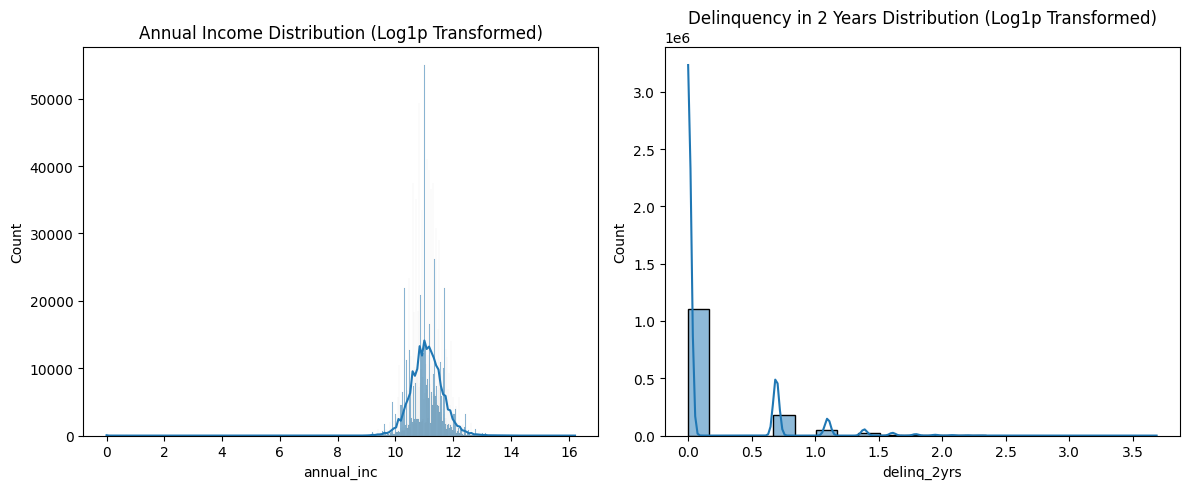

In [53]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(X_processed['annual_inc'].dropna(), kde=True) # Kernel Density Estimate True means it will plot the density curve ; annual inc looks like a normal distribution, which is much better
plt.title('Annual Income Distribution (Log1p Transformed)')
plt.subplot(1, 2, 2)
sns.histplot(X_processed['delinq_2yrs'].dropna(), kde=True)
plt.title('Delinquency in 2 Years Distribution (Log1p Transformed)')
plt.tight_layout()
plt.show()

In [55]:
# Identify columns to scale
cols_to_scale = X_processed.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumerical columns to be used with StandardScalar({len(cols_to_scale)}): {cols_to_scale}...") # print them all


Numerical columns to be used with StandardScalar(76): ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'nu

In [56]:
scaler = StandardScaler()

print("\n--- Scaling Numerical Features ---") # for the final model, StandardScaler is used only on the training set
X_processed[cols_to_scale] = scaler.fit_transform(X_processed[cols_to_scale])
print("Scaling completed.")

print("\nFirst 5 Rows of Processed DataFrame:", X_processed.head())
print("\nDescriptive Statistics of Processed DataFrame:\n")
print(X_processed[cols_to_scale].describe())


--- Scaling Numerical Features ---
Scaling completed.

First 5 Rows of Processed DataFrame:    loan_amnt        term  int_rate  installment grade sub_grade emp_length  \
0  -1.692855   36 months  0.148594    -1.638480     C        C4  10+ years   
1   1.069896   36 months -0.269458     1.242628     C        C1  10+ years   
2   0.767081   60 months -0.522380     0.269319     B        B4  10+ years   
4  -0.171057   60 months  1.916955    -0.339181     F        F1    3 years   
5   0.028245   36 months  0.033630     0.169543     C        C3    4 years   

  home_ownership  annual_inc verification_status  ... tax_liens  \
0       MORTGAGE   -0.290295        Not Verified  ...  -0.17014   
1       MORTGAGE    0.001447        Not Verified  ...  -0.17014   
2       MORTGAGE   -0.053132        Not Verified  ...  -0.17014   
4       MORTGAGE    0.829517     Source Verified  ...  -0.17014   
5           RENT   -1.130256     Source Verified  ...  -0.17014   

  tot_hi_cred_lim  total_bal_ex_mor

## Summary of Numerical Feature Preprocessing

Based on the Exploratory Data Analysis (EDA) in the previous notebook (`01_EDA_and_Data_Loading.ipynb`), many numerical features exhibited skewed distributions or were sparse (many zero values). To address this and make the distributions more symmetrical and suitable for various machine learning models, the **log1p transformation** (log(1 + x)) was applied to the following columns:

*   `loan_amnt`
*   `installment`
*   `annual_inc`
*   `dti`
*   `delinq_2yrs`
*   `inq_last_6mths`
*   `open_acc`
*   `pub_rec`
*   `revol_bal`
*   `revol_util`
*   `total_acc`
*   `collections_12_mths_ex_med`
*   `mths_since_last_major_derog`
*   `acc_now_delinq`
*   `tot_coll_amt`
*   `tot_cur_bal`
*   `open_acc_6m`
*   `open_act_il`
*   `open_il_12m`
*   `open_il_24m`
*   `mths_since_rcnt_il`
*   `total_bal_il`
*   `il_util`
*   `open_rv_12m`
*   `open_rv_24m`
*   `max_bal_bc`
*   `all_util`
*   `total_rev_hi_lim`
*   `inq_fi`
*   `total_cu_tl`
*   `inq_last_12m`
*   `acc_open_past_24mths`
*   `avg_cur_bal`
*   `bc_open_to_buy`
*   `bc_util`
*   `chargeoff_within_12_mths`
*   `delinq_amnt`
*   `mo_sin_old_il_acct`
*   `mo_sin_old_rev_tl_op`
*   `mo_sin_rcnt_rev_tl_op`
*   `mo_sin_rcnt_tl`
*   `mort_acc`
*   `mths_since_recent_bc`
*   `mths_since_recent_bc_dlq`
*   `mths_since_recent_inq`
*   `mths_since_recent_revol_delinq`
*   `num_accts_ever_120_pd`
*   `num_actv_bc_tl`
*   `num_actv_rev_tl`
*   `num_bc_sats`
*   `num_bc_tl`
*   `num_il_tl`
*   `num_op_rev_tl`
*   `num_rev_accts`
*   `num_rev_tl_bal_gt_0`
*   `num_sats`
*   `num_tl_120dpd_2m`
*   `num_tl_30dpd`
*   `num_tl_90g_dpd_24m`
*   `num_tl_op_past_12m`
*   `pct_tl_nvr_dlq`
*   `percent_bc_gt_75`
*   `pub_rec_bankruptcies`
*   `tax_liens`
*   `tot_hi_cred_lim`
*   `total_bal_ex_mort`
*   `total_bc_limit`
*   `total_il_high_credit_limit`

Following the log1p transformation (where applicable), **all numerical features** were scaled using `StandardScaler`. This is a crucial step for many machine learning algorithms (like those based on distance metrics or gradient descent) because it standardizes features by removing the mean and scaling to unit variance. This prevents features with larger values from dominating the learning process and helps algorithms converge faster and perform better.

As confirmed by the `describe()` output after scaling, the numerical columns now have means very close to 0 and standard deviations very close to 1, indicating successful standardization.

In [57]:
missing_percentage_current = (X_processed.isnull().sum() / len(X_processed)) * 100
missing_percentage_current = missing_percentage_current[missing_percentage_current > 0].sort_values(ascending=False)
print("\nMissing Percentage of Columns in Processed DataFrame:")
print(missing_percentage_current.head(20)) # There are 68 columns with missing values currently 


Missing Percentage of Columns in Processed DataFrame:
mths_since_last_record            82.954308
mths_since_recent_bc_dlq          76.309648
mths_since_last_major_derog       73.691958
mths_since_recent_revol_delinq    66.588832
il_util                           64.807319
mths_since_rcnt_il                60.384969
all_util                          59.296376
inq_last_12m                      59.292360
total_cu_tl                       59.292360
open_acc_6m                       59.292360
total_bal_il                      59.292287
open_rv_12m                       59.292287
open_il_24m                       59.292287
inq_fi                            59.292287
max_bal_bc                        59.292287
open_rv_24m                       59.292287
open_il_12m                       59.292287
open_act_il                       59.292287
mths_since_recent_inq             13.038729
num_tl_120dpd_2m                   8.872154
dtype: float64


In [58]:
numerical_cols_nans = X_processed.select_dtypes(include=[np.number]).columns[X_processed.select_dtypes(include=[np.number]).isnull().any()].tolist()
print(f"\nNumerical columns with NaN values: {numerical_cols_nans}")
for col in numerical_cols_nans:
    mode_val = X_processed[col].mode()[0]  # Get the mode value
    # X_processed[col].fillna(median_val, inplace=True)
    X_processed[col] = X_processed[col].fillna(mode_val) # This is the same as above, but more explicit and should get rid of the warning
    print(f"Imputed '{col}' with mode value: {mode_val:.2f}")

# Obviously there won't be any NaN values anymore since we already filled them with the mode value (if running this code again)


Numerical columns with NaN values: ['annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'n

In [59]:
print("\n--- Final Check for Missing Values ---")
print(X_processed.isnull().sum().sum())  # Should be 0 if all NaNs are filled, but isn't since we have some categorical columns with NaN values


--- Final Check for Missing Values ---
80401


In [60]:
categorical_features_to_encode = X_processed.select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical features to be encoded ({len(categorical_features_to_encode)}): {categorical_features_to_encode}")


Categorical features to be encoded (11): ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type', 'disbursement_method']


In [61]:
from sklearn.preprocessing import OneHotEncoder

if categorical_features_to_encode:
    encoder_one_hot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # handle_unknown='ignore' to avoid errors with unseen categories

    encoded_features = encoder_one_hot.fit_transform(X_processed[categorical_features_to_encode])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder_one_hot.get_feature_names_out(categorical_features_to_encode), index=X_processed.index)

    X_processed = X_processed.drop(columns=categorical_features_to_encode)
    X_processed = pd.concat([X_processed, encoded_df], axis=1)
    print("\nCategorical features encoded successfully.")
else:
    print("\nNo categorical features to encode.")



Categorical features encoded successfully.


In [ ]:
encoded_df # 0 means the column was not present in the original DataFrame, so it was not encoded ; 1 means the column was present and encoded

,term_ 36 months,term_ 60 months,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,...,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,disbursement_method_Cash,disbursement_method_DirectPay
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2260690,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2260691,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2260692,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [63]:
print("\n--- Final X_processed Information after transformation and encoding ---")
X_processed.info()
print("\nTotal remaining missing values in X_processed:", X_processed.isnull().sum().sum())  # Should be 0 if all NaNs are filled
print("\nFirst 5 rows of the final processed DataFrame:\n", X_processed.head())
print(f"\nFinal shape of X_processed: {X_processed.shape}")


--- Final X_processed Information after transformation and encoding ---
<class 'pandas.core.frame.DataFrame'>
Index: 1369566 entries, 0 to 2260697
Columns: 212 entries, loan_amnt to disbursement_method_DirectPay
dtypes: float64(212)
memory usage: 2.2 GB

Total remaining missing values in X_processed: 0

First 5 rows of the final processed DataFrame:
    loan_amnt  int_rate  installment  annual_inc       dti  delinq_2yrs  \
0  -1.692855  0.148594    -1.638480   -0.290295 -1.095626    -0.450015   
1   1.069896 -0.269458     1.242628    0.001447 -0.198346     1.345495   
2   0.767081 -0.522380     0.269319   -0.053132 -0.665109    -0.450015   
4  -0.171057  1.916955    -0.339181    0.829517  0.624676     1.345495   
5   0.028245  0.033630     0.169543   -1.130256 -0.716382    -0.450015   

   fico_range_low  fico_range_high  inq_last_6mths  mths_since_last_record  \
0       -0.663288        -0.663279        0.654809                0.019084   
1        0.594012         0.593995        2.5